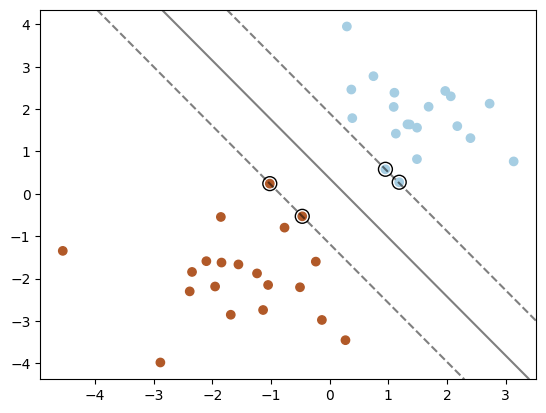

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def svm(X, y, C, tol, max_iter):
    # 初始化参数
    m, n = X.shape
    alpha = np.zeros(m)
    b = 0
    iters = 0

    # SMO优化过程
    while iters < max_iter:
        num_changed_alphas = 0
        for i in range(m):
            # 计算预测值和误差
            f_i = np.dot(alpha * y, np.dot(X, X[i])) + b
            E_i = f_i - y[i]

            # KKT条件验证
            if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):
                # 选择第二个变量alpha_j
                j = np.random.choice([x for x in range(m) if x != i])

                # 计算预测值和误差
                f_j = np.dot(alpha * y, np.dot(X, X[j])) + b
                E_j = f_j - y[j]

                # 保存旧的alpha值
                alpha_i_old = alpha[i]
                alpha_j_old = alpha[j]

                # 计算上下界L和H
                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])

                # 计算eta
                eta = 2 * np.dot(X[i], X[j]) - np.dot(X[i], X[i]) - np.dot(X[j], X[j])

                if eta >= 0:
                    continue

                # 更新alpha_j
                alpha[j] = alpha[j] - (y[j] * (E_i - E_j)) / eta

                # 修剪alpha_j
                alpha[j] = min(H, alpha[j])
                alpha[j] = max(L, alpha[j])

                # 检查alpha_j是否有足够变化
                if abs(alpha[j] - alpha_j_old) < 1e-5:
                    continue

                # 更新alpha_i
                alpha[i] = alpha[i] + y[i] * y[j] * (alpha_j_old - alpha[j])

                # 更新b
                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * np.dot(X[i], X[i]) - y[j] * (alpha[j] - alpha_j_old) * np.dot(X[i], X[j])
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * np.dot(X[i], X[j]) - y[j] * (alpha[j] - alpha_j_old) * np.dot(X[j], X[j])

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                num_changed_alphas += 1

        # 判断是否收敛
        if num_changed_alphas == 0:
            iters += 1
        else:
            iters = 0

    # 计算权重向量w
    w = np.dot((alpha * y).reshape(1, -1), X)

    return w, b

# 生成线性可分的数据集
np.random.seed(0)
X = np.concatenate([np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]])
y = np.concatenate([np.ones(20), -np.ones(20)])

# 调用SVM函数进行训练
C = 1.0  # 惩罚因子
tol = 0.001  # 容忍度
max_iter = 1000  # 最大迭代次数
w, b = svm(X, y, C, tol, max_iter)

# 绘制数据集和决策边界
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 生成网格点并预测分类
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = np.dot(xy, w.T) + b

# 绘制决策边界和支持向量
Z = Z.reshape(XX.shape)
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.1)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.1)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.1)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.1)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')
plt.show()